In [90]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

RENDER_HUMAN = False
if RENDER_HUMAN:
    env = gym.make('Pendulum-v1', render_mode="human")
else:
    env = gym.make('Pendulum-v1')

print("Action Space: ", env.action_space)
print("Obs Space: ", env.observation_space)


SEED = 2147483647
# torch.manual_seed(SEED)

Action Space:  Box(-2.0, 2.0, (1,), float32)
Obs Space:  Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


In [6]:
observation, info = env.reset(seed=SEED)

for _ in range(20):
    env.render()    

    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    
    clear_output(wait=True)
    print(observation, reward, terminated, truncated, info)  # use disp

    if terminated or truncated:
        observation, info = env.reset(seed=SEED)

env.close()


[ 0.5086698 -0.8609617  3.2771099] -2.8454853621064653 False False {}


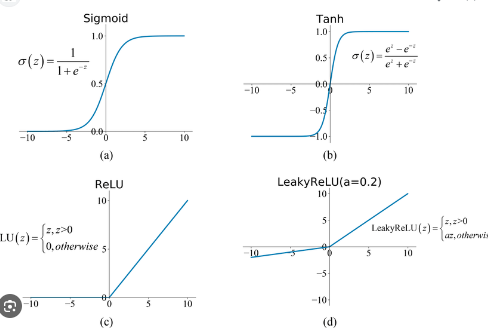


The new Neuron

1 layer network

Idea for x
- all values to be between -1 and 1. Numbers work out nicely, "lower variance"?
- Dynamically scale. If you are in a dark room for a while, then you can start to see the darks agian.

y = wx + b - ke 

https://www.reddit.com/r/reinforcementlearning/comments/g53340/tanh_activation_for_action_1_1/


action = tanh(Wx + b - ke)

Lets start with a single neuron layer.

To maximie reward we want x = 0 (upright)

x = joint position

when x is -1 action should be positive torque so 1.

So w should be -1

assume we are just use the p term...

how to calculate error?

what is the ground truth of action? Doesn't exist...

Policy gradient? If I want to do online, I belive I need bootstrapping method.... TD

The error can be from actions or state predictions...

If I knew the right action to take, then I could do it.

Mabye I don't know the right action, but I know what action I do want to take.

Step 1. (Sit and watch)

Observation. 
- Predict how the world is
- We learn a model of the "agent" 

Step 2. (Crawl)
Predicting how the world/how we want the world to be.

Predict how we want the world to be. (0-1 scale of how grounded in reality we want the robot to be).





In [99]:
g = torch.Generator().manual_seed(2147483647)

# Create NN Parameters
W1 = torch.randn((3,30), generator=g, requires_grad=True)
b1 = torch.randn((30), generator=g, requires_grad=True)

W2 = torch.randn((30,3), generator=g, requires_grad=True)
b2 = torch.randn((3), generator=g, requires_grad=True)

params = [W1, b1, W2, b2]

n_params = sum(p.numel() for p in params)

print("Network Params: ", n_params)

Network Params:  213


In [114]:
observation, info = env.reset(seed=SEED)

curr_obs_raw, info = env.reset(seed=SEED)
curr_obs = curr_obs_raw/np.array([1,1,8]) 
curr_obs = torch.Tensor(curr_obs)

action = env.action_space.sample()  #first action is random

losses = []  
time_steps = []  

for _ in range(1000):
    
    # Forward Pass, make prediction based on current state
    l1 = F.relu(curr_obs @ W1 + b1)
    output = l1 @ W2 + b2

    next_obs_pred = torch.tanh(output)

    # time step forward
    next_obs_raw, reward, terminated, truncated, info = env.step(action)

    next_obs = next_obs_raw/np.array([1,1,8]) 
    next_obs = torch.Tensor(next_obs)

    # Backward pass - calculate prediction error + backprop

    loss = F.mse_loss(next_obs_pred, next_obs)

    loss_val = loss.item()
    # if loss_val > 0.02:
    #     print(loss_val)
    #     print(next_obs_pred)
    #     print(next_obs)
    #     time.sleep(2)

    losses.append(loss.item())
    time_steps.append(_)

    # print("{} ---> {}".format(next_obs_pred, next_obs))
    # print(loss.item())
    curr_obs = next_obs # reassign for next loop

    for p in params:
        p.grad = None

    loss.backward()

    for p in params:
        p.data += -0.1 * p.grad

    if terminated or truncated:
        print("Reseting on step: ", _)
        curr_obs_raw, info = env.reset(seed=SEED)
        curr_obs = curr_obs_raw/np.array([1,1,8]) 
        curr_obs = torch.Tensor(curr_obs)

env.close()

Reseting on step:  199
Reseting on step:  399
Reseting on step:  599
Reseting on step:  799
Reseting on step:  999


0.0012012104546902061


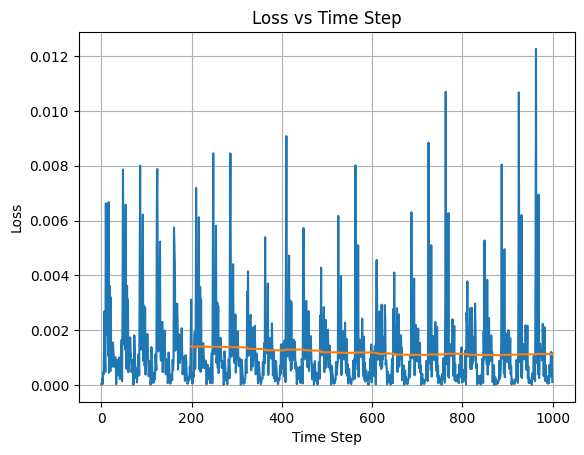

In [116]:
smooth_loss = np.convolve(losses, np.ones(200) / 200, mode='valid')
print(np.mean(smooth_loss))
plt.plot(time_steps, losses, label='Raw Loss')
plt.plot(time_steps[len(time_steps) - len(smooth_loss):], smooth_loss, label='Smoothed Loss')
plt.xlabel('Time Step')
plt.ylabel('Loss')
plt.title('Loss vs Time Step')
plt.grid(True)
plt.show()

Random Weights

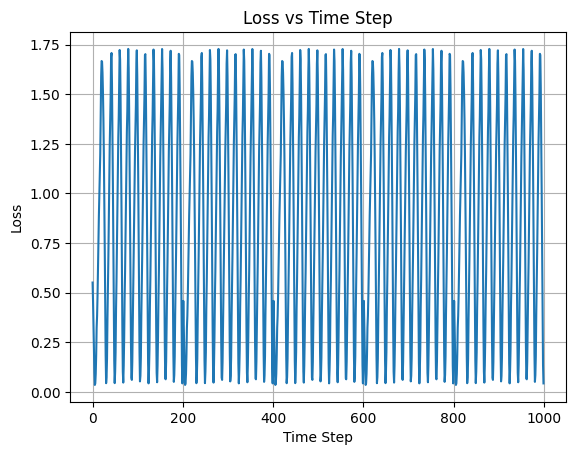

With Training

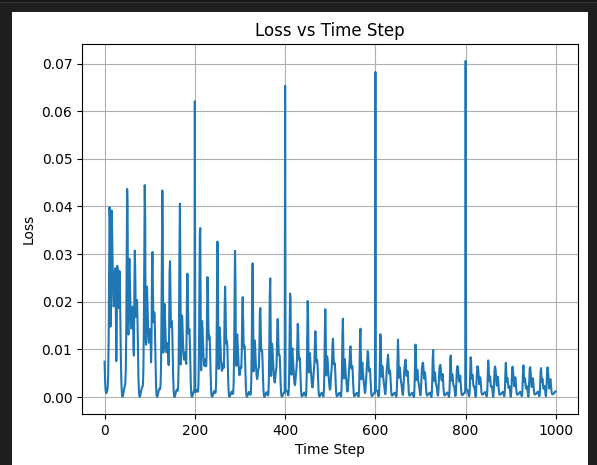

for 10k time steps

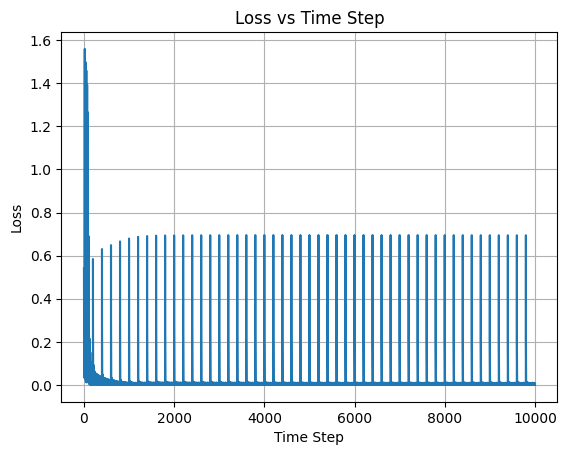

If I increase network capacity can I get rid of the spikes?

Spikes are due to random reset! You cannot get rid of them IMO

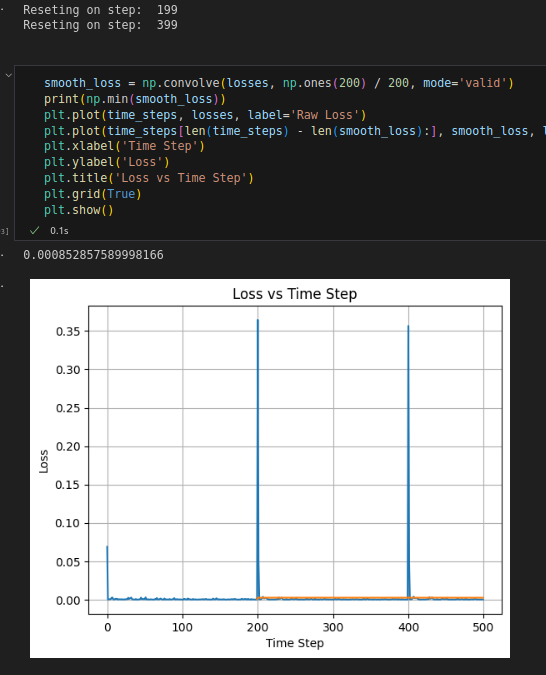

This code fixed it:

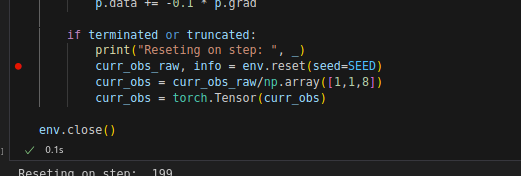

Scale observations so all within [-1,1]

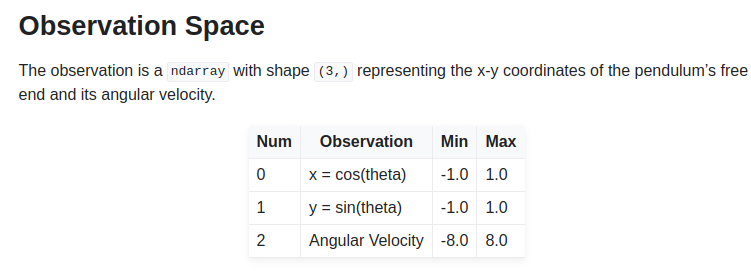